# Домашнее задание 4

Это домашнее задание по материалам второго семинаров. Дедлайн по отправке - 23:55 3 марта. 

Домашнее задание выполняется в этом же Jupyter Notebook'e и присылается мне на почту: __beznosikov.an@phystech.edu__.

Решение каждой задачи необходимо поместить после её условия.

Файл должен называться: Фамилия_Имя_Optimization_HW_4

При полном запуске Вашего решения (Kernel -> Restart & Run All) все ячейки должны выполняться без ошибок. 

## Задача 1

Рассмотрим задачу минимизации:
\begin{equation}
\min_{x \in \triangle_d} f(x) = \frac{1}{2}x^T A x,
\end{equation}
где в качестве матрицы $A$ - случайная матрица (уже умеем генерировать) с $L =1000$, $\mu = 1$, а $\triangle_d$ - вероятностный симплекс:
$$
\triangle_d = \{x ~|~ x_i \geq 0, \sum_{i=1}^d x_i = 1\}.
$$

__(а)__ Для такой задачи напишите итерацию зеркального спуска с дивергенцией Брегмана, порожденной энтропийной функцией. Найдите выражение для итерации метода в явном виде (без подсчетов $\arg\min$).

In [36]:
import time
import numpy as np 
import matplotlib.pyplot as plt 
import math

In [37]:
#matrix generation, from first homework
import numpy as np 
from numpy import linalg 

def rvs(dim=3):
     random_state = np.random
     H = np.eye(dim)
     D = np.ones((dim,))
     for n in range(1, dim):
         x = random_state.normal(size=(dim-n+1,))
         D[n-1] = np.sign(x[0])
         x[0] -= D[n-1]*np.sqrt((x*x).sum())
         # Householder transformation
         Hx = (np.eye(dim-n+1) - 2.*np.outer(x, x)/(x*x).sum())
         mat = np.eye(dim)
         mat[n-1:, n-1:] = Hx
         H = np.dot(H, mat)
     D[-1] = (-1)**(1-(dim % 2))*D.prod()
     H = (D*H.T).T
     return H
    
def generate_matrix(d, m, L):  
    A = np.eye(d) 
    A[0, 0] = L
    A[1, 1] = m
    S = rvs(d) 
    A = np.dot(np.linalg.inv(S), np.dot(A, S))
    return A 

Шаг зеркального спуска c дивергенцией Брегмана, порожденной энтропийной функцией: 
    $$ x^{k + 1} =  argmin_{x \in \triangle_{d}} (\nabla f(x^{k}), x) + \sum_{i}^{d} x_{i}ln \cfrac{x_{i}}{x_{i}^{k}}$$ 

Воспользуемся тем, что норма к симплекс методу есть вектор, состоящий из единиц.  
Тогда, градиент в точке $x^{k + 1}$ должен быть параллелен ей. То есть получаем, что: 
$$\nabla f(x_{i}^{k + 1}) = \nabla f(x_{i}^{k}) + ln\cfrac{x_{i}^{k + 1}}{x_{i}^{k}} + 1 = \alpha \cdot 1$$

Отсюда найдем $$x_{i}^{k + 1} = x_{i}^{k}exp(-\nabla f(x_{i}^{k}))exp(\alpha - 1)$$

Константу найдем из условия того, что $$\sum_{i = 1}^{d} x_{i}^{k + 1} = 1$$

$$exp(\alpha - 1) = \cfrac{1}{\sum_{i = 1}^{d} x_{i}^{k}exp(-\nabla f(x_{i}^{k}))}$$

$$x_{i}^{k + 1} = \cfrac{x_{i}^{k}exp(-\nabla f(x_{i}^{k}))}{\sum_{i = 1}^{d}x_{i}^{k}exp(-\nabla f(x_{i}^{k}))}$$

__(б)__ Реализуйте метод зеркального спуска из пункта (а). Постройте для него график сходимости по времени и по итерациям. В качестве критерия сходимости используйте:
$$
\text{gap}(x^k) = \max_{y \in \triangle_d} \langle \nabla f(x^k), x^k - y \rangle,
$$
или усредненную версию $\frac{1}{k} \sum_{i=1}^k \text{gap}(x^i)$. Найдите выражение в явном виде для подсчета $\text{gap}(x^k)$.

Пользуясь тем, что мы работаем на вероятностном симплексе, мы можем, не записывая ККТ, сделать вывод, что: 

$$gap(x^{k}) = \nabla f^{T}(x^{k})x^{k} - min_{i}(\nabla f(x_{i}^{k}))$$

In [203]:
import math  
eps = 1e-6
class MirrorDescent: 
    def __init__(self, d, alpha = 1e-3, max_iter = 10000): 
        self.d = d 
        self.A = generate_matrix(self.d, 1, 1000) 
        self.x = None 
        self.gap_history = []  
        self.max_iter = max_iter 
        self.alpha = alpha  
        self.time_history = []
        
    def f(self): 
        return 1/2 * np.dot(x.T, np.dot(A, x))
        
    def grad_f(self): 
        return 1/2 * np.dot((self.A.T + self.A), self.x)
    
    def fit(self):  
        self.x = np.ones(self.d) 
        self.x /= self.d
        time_start = time.time() 
        for i in range(self.max_iter): 
            g = self.grad_f() 
            
            self.x = self.x * np.exp(-self.alpha * g) / np.sum(self.x * np.exp(-self.alpha * g))
            self.gap_history.append(np.dot(g.T, self.x) - np.min(g))  
            self.time_history.append(time.time() - time_start)

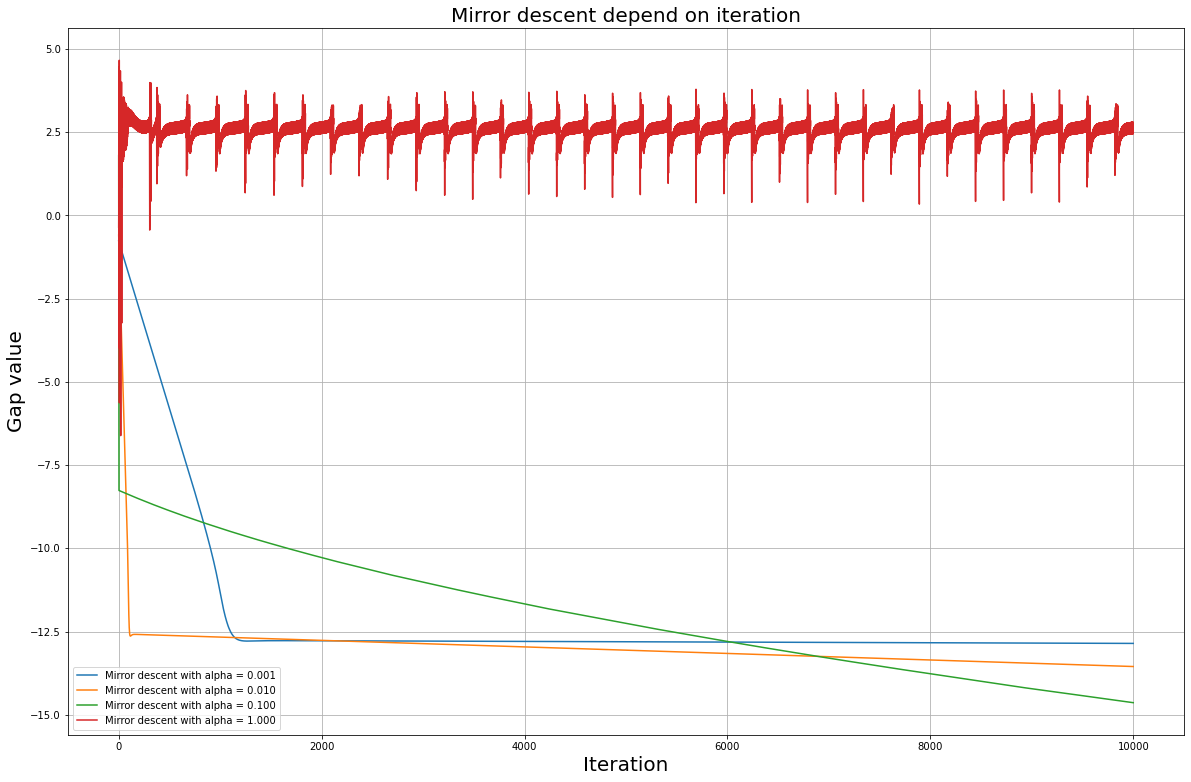

In [204]:
import matplotlib.pyplot as plt  
plt.figure(figsize=(20, 13)) 
plt.title('Mirror descent depend on iteration', fontsize=20) 
alpha = [0.001, 0.01, 0.1, 1] 
for a in alpha:  
    md = MirrorDescent(100, a) 
    md.fit()
    plt.plot(range(md.max_iter), np.log(md.gap_history), label='Mirror descent with alpha = %5.3f' % a)  
plt.xlabel('Iteration', fontsize=20)  
plt.ylabel('Gap value', fontsize=20)
plt.legend()
plt.grid() 
plt.show()

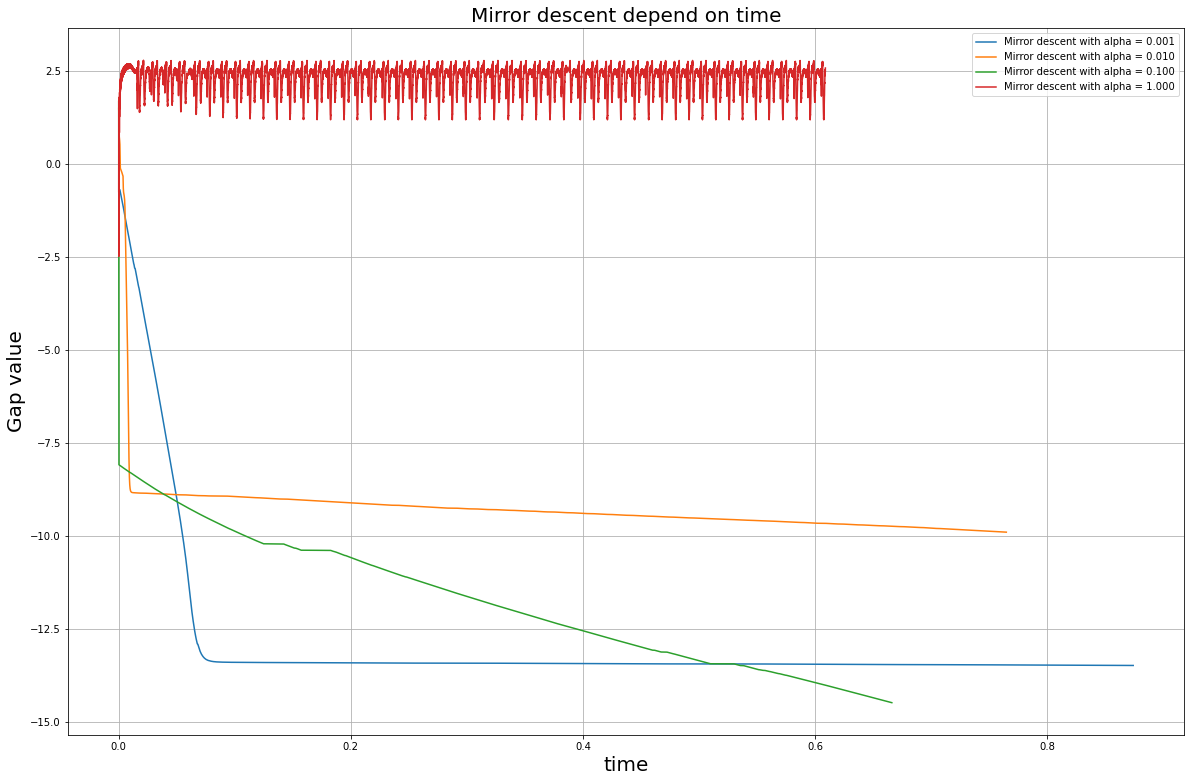

In [205]:
import time  
plt.figure(figsize=(20, 13)) 
plt.title('Mirror descent depend on time', fontsize=20) 
alpha = [0.001, 0.01, 0.1, 1] 
for a in alpha:  
    md = MirrorDescent(100, a) 
    md.fit()
    plt.plot(md.time_history, np.log(md.gap_history), label='Mirror descent with alpha = %5.3f' % a)  
plt.xlabel('time', fontsize=20)  
plt.ylabel('Gap value', fontsize=20)
plt.legend()
plt.grid() 
plt.show()

__(в)__ Для этой же задачи напишите итерацию метода Франка-Вульфа. Реализуйте этот метод. Постройте для него график сходимости по времени и по итерациям. Добавьте эти графики к графикам для зеркального спуска. Сделайте вывод.

In [206]:
class Frank_Wolfie: 
    def __init__(self, d, max_iter=10000): 
        self.d = d  
        self.max_iter = max_iter 
        self.A = generate_matrix(self.d, 1, 1000)  
        self.gap_history = [] 
        self.time_history = [] 
        self.x = None  
        
    def grad_f(self): 
        return 1/2 * np.dot((self.A.T + self.A), self.x) 
    
    def fit(self): 
        self.x = np.ones(self.d) 
        s = np.zeros(self.d)   
        s /= self.d
        time_start = time.time()
        alpha = 1
        
        for i in range(self.max_iter):   
            alpha = 2/(i + 2)
            g = self.grad_f()   
            
            min_val = np.min(g)
            min_idx = np.where(g == min_val)[0]
            s[min_idx] = 1 / len(min_idx)  
            
            self.x = (1 - alpha) * self.x + alpha * s 
            
            self.gap_history.append(np.dot(g.T, self.x) - np.min(g)) 
            self.time_history.append(time.time() - time_start) 
            s = np.zeros(self.d)

In [207]:
fw = Frank_Wolfie(100) 
fw.fit()

In [208]:
md = MirrorDescent(100) 
md.fit()

/tmp/ipykernel_200505/3044705612.py:3: RuntimeWarning: divide by zero encountered in log
  plt.plot(range(fw.max_iter), np.log(fw.gap_history), label='Frank_Wolfie')


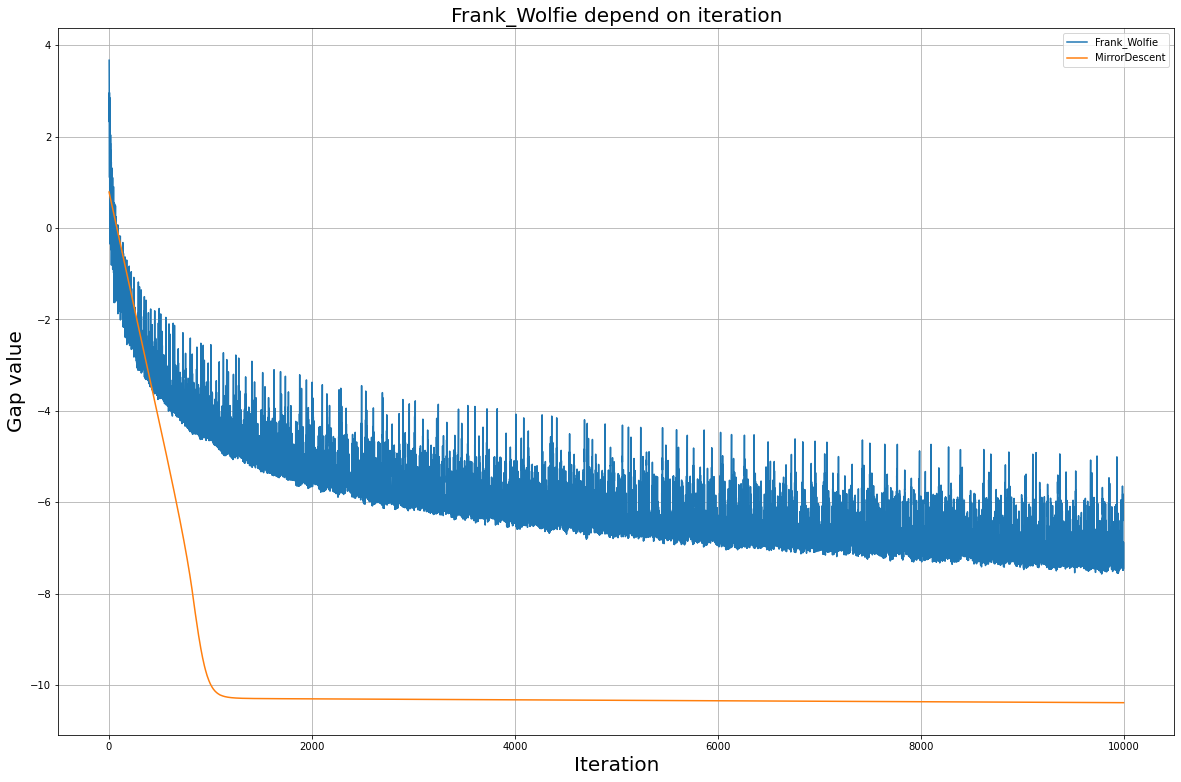

In [209]:
plt.figure(figsize=(20, 13)) 
plt.title('Frank_Wolfie depend on iteration', fontsize=20) 
plt.plot(range(fw.max_iter), np.log(fw.gap_history), label='Frank_Wolfie')   
plt.plot(range(md.max_iter), np.log(md.gap_history), label='MirrorDescent')
plt.xlabel('Iteration', fontsize=20)  
plt.ylabel('Gap value', fontsize=20)
plt.legend()
plt.grid() 
plt.show()

/tmp/ipykernel_200505/981823102.py:3: RuntimeWarning: divide by zero encountered in log
  plt.plot(fw.time_history, np.log(fw.gap_history), label='Frank_Wolfie')


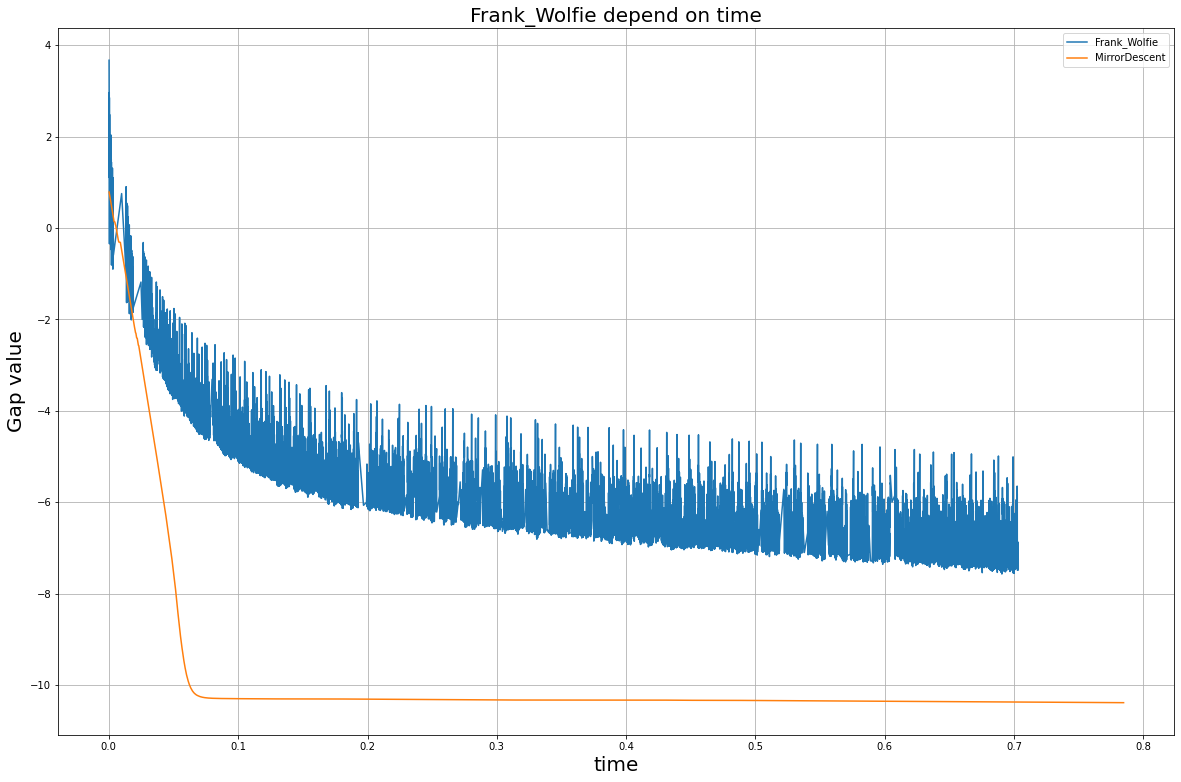

In [210]:
plt.figure(figsize=(20, 13)) 
plt.title('Frank_Wolfie depend on time', fontsize=20) 
plt.plot(fw.time_history, np.log(fw.gap_history), label='Frank_Wolfie')   
plt.plot(md.time_history, np.log(md.gap_history), label='MirrorDescent')
plt.xlabel('time', fontsize=20)  
plt.ylabel('Gap value', fontsize=20)
plt.legend()
plt.grid() 
plt.show()

__Бонусные пункты__

__(г)__ Реализуйте метод градиентного спуска для нашей задачи. Для этого найдите в Интернете алгоритм евклидовой проекции на вероятностный симплекс. Постройте для градиентного спуска с евклидовой проекцией график сходимости по времени и по итерациям. Добавьте эти графики к графикам для зеркального спуска и метода Франка-Вульфа. Сделайте вывод.

In [211]:
d = 100

In [212]:
A = generate_matrix(d, 1, 1000)  

In [213]:
def grad(A, x): 
    return 1/2 * np.dot((A.T + A), x) 

In [214]:
def f(A, x): 
    return 1/2 * np.dot(x, np.dot(A, x))

In [215]:
import time

In [216]:
def projl2(y): 
    y_sorted = np.sort(y)[::-1] 
    s = 0  
    ro = 0 
    sum_ro = 0 
    for i in range(len(y)): 
        s += y_sorted[i] 
        if(y_sorted[i] + 1/(i + 1) * (1 - s) > 0): 
            ro = i + 1
            sum_ro = s  
    l = 1/ro * (1 - sum_ro)  
    x = np.zeros(len(y))
    for i in range(len(y)): 
        x[i] = max(y[i] + l, 0) 
    return x 

In [217]:
class GradientDescent: 
    def __init__(self, A, d, max_iter=10000): 
        self.d = d 
        self.max_iter = max_iter
        self.A = A  
        self.gap_history = [] 
        self.time_history = []  
        self.x = None 
        self.lr = 1/1000 
        
    def fit(self): 
        self.x = 1/self.d * np.ones(self.d)   
        time_start = time.time()
        for i in range(self.max_iter):
            g = grad(self.A, self.x)
            self.x = projl2(self.x - self.lr * g) 
            self.gap_history.append(np.dot(g.T, self.x) - np.min(g)) 
            self.time_history.append(time.time() - time_start) 

In [218]:
gd = GradientDescent(A, d) 

In [219]:
gd.fit() 

/tmp/ipykernel_200505/377218788.py:3: RuntimeWarning: divide by zero encountered in log
  plt.plot(range(fw.max_iter), np.log(fw.gap_history), label='Frank_Wolfie')


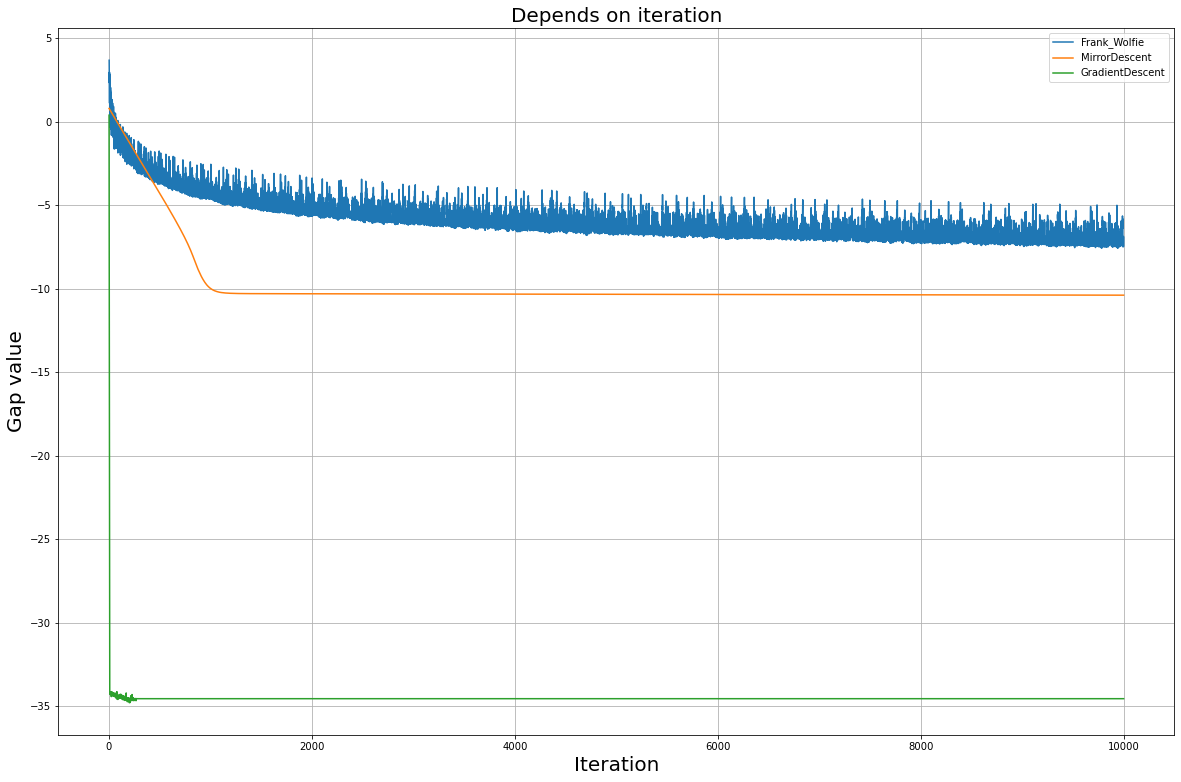

In [220]:
plt.figure(figsize=(20, 13)) 
plt.title('Depends on iteration', fontsize=20) 
plt.plot(range(fw.max_iter), np.log(fw.gap_history), label='Frank_Wolfie')   
plt.plot(range(md.max_iter), np.log(md.gap_history), label='MirrorDescent') 
plt.plot(range(gd.max_iter), np.log(gd.gap_history), label='GradientDescent')
plt.xlabel('Iteration', fontsize=20)  
plt.ylabel('Gap value', fontsize=20)
plt.legend()
plt.grid() 
plt.show()

/tmp/ipykernel_200505/112084237.py:3: RuntimeWarning: divide by zero encountered in log
  plt.plot(fw.time_history, np.log(fw.gap_history), label='Frank_Wolfie')


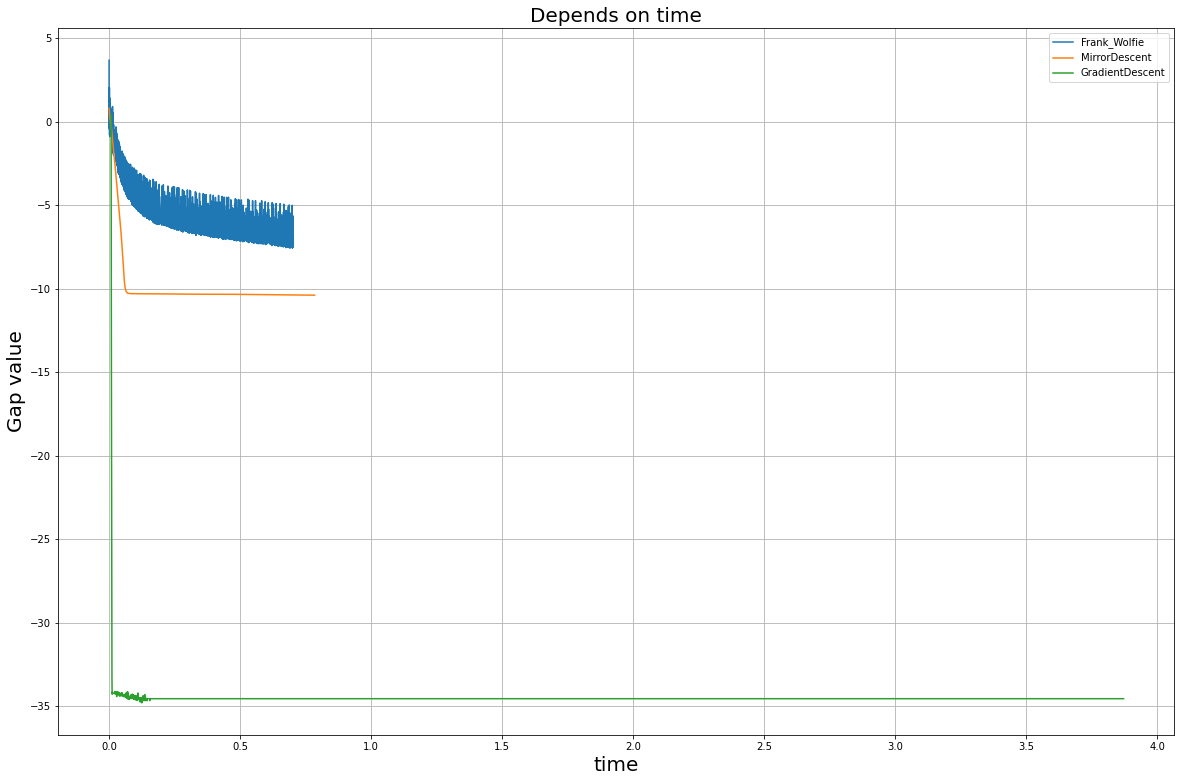

In [221]:
plt.figure(figsize=(20, 13)) 
plt.title('Depends on time', fontsize=20) 
plt.plot(fw.time_history, np.log(fw.gap_history), label='Frank_Wolfie')   
plt.plot(md.time_history, np.log(md.gap_history), label='MirrorDescent') 
plt.plot(gd.time_history, np.log(gd.gap_history), label='GradientDescent')
plt.xlabel('time', fontsize=20)  
plt.ylabel('Gap value', fontsize=20)
plt.legend()
plt.grid() 
plt.show()

## Здесь сразу видим, что проекция градиентного спуска сходится, очень быстро, a также превосходит другие методы. Также проекция работает сильно дольше  из-за асимптотики dlog(d) для взятия этой самой проекции.

__(д)__ В [работе](https://sci-hub.ru/https://doi.org/10.1137/140992382) представлена ускоренная версия метода Франка-Вульфа (Алгоритм 2 для сильно выпуклой задачи). Он лучше с точки зрения теоретической сходимости по числу вызовов градиента. Реализуйте Алгоритм 2 для нашей задачи. Постройте график сходимости по времени и по количеству подсчетов $\nabla f$ (для предыдущих методов это было эквивалетно итерациям). Добавьте эти графики к графикам для остальных методов которые были получены выше. Сделайте вывод.

In [222]:
d = 100 
L = 1000 
mu = 1

In [223]:
def CGS(gradi, u, b, e): 
    u_new = u
    while True:
        v = np.zeros(len(u))
        mini = (gradi + b * (u_new - u))[0]
        j = 0
        for i in range(1, len(u)):
            if (gradi + b * (u_new - u))[i] < mini:
                mini = (gradi + b * (u_new - u))[i]
                j = i
        v[j] = 1
        cr = (gradi + b * (u_new - u)).T @ u_new - np.min(gradi + b * (u_new - u))
        if cr <= e:
            return u_new
        a = min(1, ((b * (u - u_new) - gradi).T @ (v - u_new)) / (b * np.linalg.norm(v - u_new)**2))
        u_new = (1 - a) * u_new + a * v

In [224]:
class FrankWolfieFast: 
    def __init__(self, A, d, mu, L, max_iter=1000, iters=10): 
        self.A = A 
        self.d = d 
        self.mu = mu
        self.L = L 
        self.gap_history = [] 
        self.time_history = [] 
        self.call_gradi = []   
        self.x = None 
        self.max_iter = max_iter 
        self.iters = iters  
        
    def fit(self): 
        self.x = np.random.uniform(low=0, high=1, size=(self.d))
        p0 = self.x / np.linalg.norm(self.x) 
        p0[1] = 1 
        delta = f(A, p0)
        N = math.ceil(2 * math.sqrt(6 * self.L / self.mu))  
        times_of_calling = 0 
        
        time_start = time.time()  
        self.x = p0 
        y_new = self.x
        for s in range(1, self.iters + 1, 1):
            #self.x = p0 
            #y_new = self.x   
            for i in range(1, self.max_iter + 1, 1):  
                z = (1 - 2/(i + 1)) * y_new + 2/(i + 1) * self.x
                xi = CGS(grad(A, z), self.x, 2 * L/i, 8 * L * delta * 2**(-s) / (mu * N * i)) 
                y = (1 - 2/(i + 1)) * y_new + 2/(i + 1) * xi
                self.x = xi
                y_new = y 
                self.time_history.append(time.time() - time_start)  
                g = grad(A, y_new)
                self.gap_history.append(np.dot(g.T, y_new) - np.min(g))

In [225]:
fwf = FrankWolfieFast(A, d, mu, L) 

In [226]:
fwf.fit() 

/tmp/ipykernel_200505/728330701.py:4: RuntimeWarning: divide by zero encountered in log
  plt.plot(range(fw.max_iter), np.log(fw.gap_history), label='Frank_Wolfie')


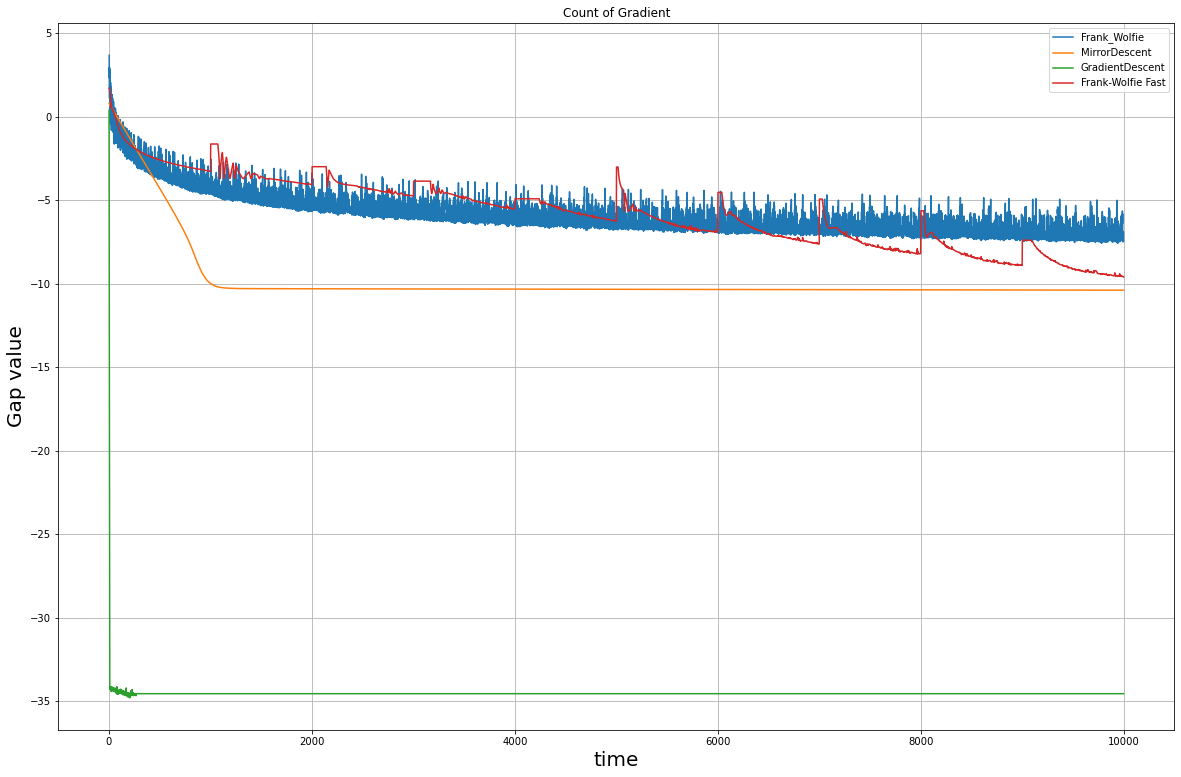

In [227]:
plt.figure(figsize=(20,13)) 
plt.grid() 
plt.title('Count of Gradient')  
plt.plot(range(fw.max_iter), np.log(fw.gap_history), label='Frank_Wolfie')    
plt.plot(range(md.max_iter), np.log(md.gap_history), label='MirrorDescent')  
plt.plot(range(gd.max_iter), np.log(gd.gap_history), label='GradientDescent')  
plt.plot(range(1, fwf.iters * fwf.max_iter + 1, 1), np.log(fwf.gap_history), label='Frank-Wolfie Fast')
plt.xlabel('time', fontsize=20)  
plt.ylabel('Gap value', fontsize=20)
plt.legend() 
plt.show() 

/tmp/ipykernel_200505/1630756014.py:4: RuntimeWarning: divide by zero encountered in log
  plt.plot(fw.time_history, np.log(fw.gap_history), label='Frank_Wolfie')


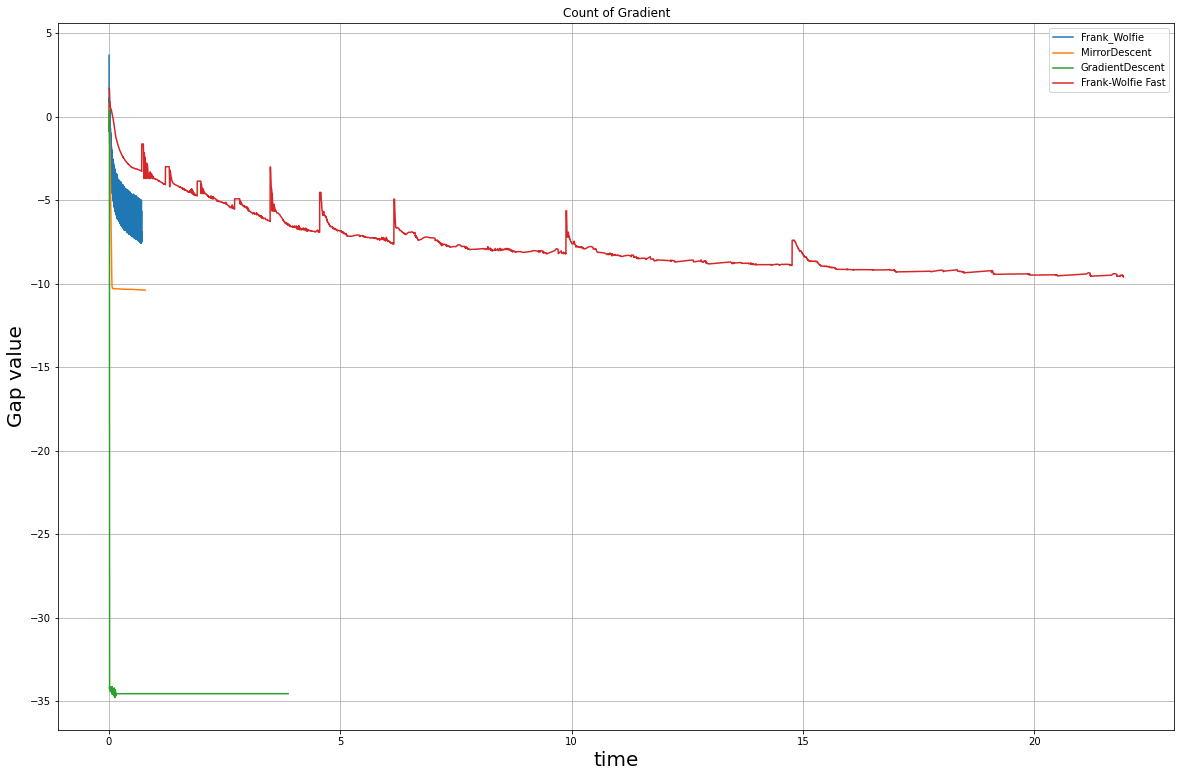

In [228]:
plt.figure(figsize=(20,13)) 
plt.grid() 
plt.title('Count of Gradient')  
plt.plot(fw.time_history, np.log(fw.gap_history), label='Frank_Wolfie')    
plt.plot(md.time_history, np.log(md.gap_history), label='MirrorDescent')  
plt.plot(gd.time_history, np.log(gd.gap_history), label='GradientDescent')  
plt.plot(fwf.time_history, np.log(fwf.gap_history), label='Frank-Wolfie Fast')
plt.xlabel('time', fontsize=20)  
plt.ylabel('Gap value', fontsize=20)
plt.legend() 
plt.show()

## Таким Образом можно заметить, что улучшенная версия метода Франка-Вульфа ведет себя немного лучше в плане затухания градиента, так как мы видим, более крутой наклон, однако это улучшение не дает заметного преимущества. Возможно можно подобрать более подходящие гиперпараметры для данного метода. Также стоит отметить, что он работает на самом деле то дольше чем обычный метод.

## Но все же абсолютным победителем остается градиентный спуск.